In [1]:
import random
from tqdm import tqdm
import torch,torchvision
from torch.nn import *
from torch.optim import *
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import wandb
import os
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
PROJECT_NAME = 'Fake-Face-V1'
device = 'cuda'
IMG_SIZE = 224

In [2]:
transformations = torchvision.transforms.Compose(
[torchvision.transforms.ToTensor()]
)

In [3]:
def load_data(data_dir='./data/'):
    idx = -1
    data = []
    for file in tqdm(os.listdir(data_dir)):
        idx += 1
        file = data_dir + file
        img = cv2.imread(file)
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        data.append(np.array(transformations(np.array(img))))
    return data

In [7]:
data = load_data()

100%|██████████| 1081/1081 [00:10<00:00, 100.79it/s]


In [8]:
data = torch.from_numpy(np.array(data))

In [9]:
# torch.save(data,'data.pt')
# torch.save(data,'data.pth')

In [10]:
# data = torch.load('data.pt')

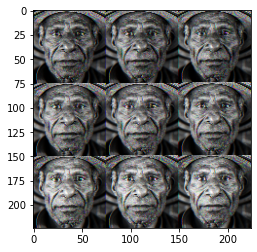

In [13]:
plt.imshow(data[0].view(IMG_SIZE,IMG_SIZE,3))

In [14]:
class Desc(Module):
    def __init__(self,starter=512,activation=ReLU()):
        super().__init__()
        self.dropout = Dropout()
        self.activation = activation
        self.linear1 = Linear(IMG_SIZE*IMG_SIZE*3,starter)
        self.linear1batchnorm = BatchNorm1d(starter)
        self.linear2 = Linear(starter,starter*2)
        self.linear2batchnorm = BatchNorm1d(starter*2)
        self.linear3 = Linear(starter*2,starter*2*2)
        self.linear3batchnorm = BatchNorm1d(starter*2*2)
        self.linear4 = Linear(starter*2*2,starter*2)
        self.linear4batchnorm = BatchNorm1d(starter*2)
        self.output = Linear(starter*2,1)
        self.output_activation = Sigmoid()
        
    def forward(self,X):
        preds = self.dropout(self.activation(self.linear1batchnorm(self.linear1(X))))
        preds = self.dropout(self.activation(self.linear2batchnorm(self.linear2(preds))))
        preds = self.dropout(self.activation(self.linear3batchnorm(self.linear3(preds))))
        preds = self.dropout(self.activation(self.linear4batchnorm(self.linear4(preds))))
        preds = self.output_activation(self.output(preds))
        return preds

In [15]:
class Gen(Module):
    def __init__(self,z_dim,starter=512,activation=ReLU()):
        super().__init__()
        self.dropout = Dropout()
        self.activation = activation
        self.linear1 = Linear(z_dim,starter)
        self.linear1batchnorm = BatchNorm1d(starter)
        self.linear2 = Linear(starter,starter*2)
        self.linear2batchnorm = BatchNorm1d(starter*2)
        self.linear3 = Linear(starter*2,starter*2*2)
        self.linear3batchnorm = BatchNorm1d(starter*2*2)
        self.linear4 = Linear(starter*2*2,starter*2)
        self.linear4batchnorm = BatchNorm1d(starter*2)
        self.output = Linear(starter*2,IMG_SIZE*IMG_SIZE*3)
        self.output_activation = Tanh()
        
    def forward(self,X):
        preds = self.dropout(self.activation(self.linear1batchnorm(self.linear1(X))))
        preds = self.dropout(self.activation(self.linear2batchnorm(self.linear2(preds))))
        preds = self.dropout(self.activation(self.linear3batchnorm(self.linear3(preds))))
        preds = self.dropout(self.activation(self.linear4batchnorm(self.linear4(preds))))
        preds = self.output_activation(self.output(preds))

In [17]:
z_dim = 64
gen = Gen(z_dim).to(device)
desc = Desc().to(device)
lr = 3e-4
batch_size = 32
epochs = 100
optimizer_gen = Adam(gen.parameters(),lr=lr)
optimizer_desc = Adam(desc.parameters(),lr=lr)
criterion = BCELoss()
fixed_noise = torch.randn((batch_size,z_dim)).to(device)

In [ ]:
for _ in tqdm(range(epochs)):
    for idx in range(0,len(data),batch_size):
        data_batch = data[idx:idx+batch_size].view(IMG_SIZE*IMG_SIZE*3).float().to(device)
        batch_size = data_batch.shape[0]
        noise = torch.randn((batch_size,z_dim)).to(device)
        fake = gen(noise)
        desc_fake = desc(fake)
        lossD_fake = criterion(desc_fake,torch.zeros_like(desc_fake))
        desc_real = desc(data_batch)
        lossD_real = criterion(desc_real,torch.ones_like(desc_real))
        lossD = (lossD_fake/lossD_real)/2
        desc.zero_grad()
        lossD.backward(retain_graph=True)
        wandb.log({'lossD':lossD.item()})
        optimizer_desc.step()
        output = desc(fake).view(-1)
        lossG = criterion(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        wandb.log({'lossG':lossG.item()})
        optimizer_gen.step()
        